# EPL Fixture Outcome Predictions

The objective of this model is to forecast the outcomes of EPL games based on historical data. The goal is to analyse the data to identify patterns and factors that most significantly influence game outcomes, enabling accurate predictions for future matches. 

The model aims to provide invaluable information for team strategy development and fan engagement.

In [1]:
# Data Wrangling Libraries
import pandas as pd
import numpy as np

# Visualisation Libraries
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.inspection import permutation_importance


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data

The following data was originally sourced from [Football-Data.Co.uk](https://www.football-data.co.uk/englandm.php)

In [3]:
# URL of the CSV file
url = 'https://raw.githubusercontent.com/redbackoperations/Projects/main/Sports%20Performance%20Analysis/frontend/Football%20Analysis/data/consol_epl_results_raw.csv'

# Read the CSV file directly from the URL
df = pd.read_csv(url)

# Display the first 10 rows
df.head(10)


,Unnamed: 0,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,0,E0,13/08/05,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,E0,13/08/05,Everton,Man United,0.0,2.0,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,E0,13/08/05,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,E0,13/08/05,Man City,West Brom,0.0,0.0,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,E0,13/08/05,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,E0,13/08/05,Portsmouth,Tottenham,0.0,2.0,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,E0,13/08/05,Sunderland,Charlton,1.0,3.0,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,E0,13/08/05,West Ham,Blackburn,3.0,1.0,H,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,E0,14/08/05,Arsenal,Newcastle,2.0,0.0,H,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,E0,14/08/05,Wigan,Chelsea,0.0,1.0,A,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing Data & Feature Selection

In [4]:
# Determine the percentage of missing values each column
missing_values_percent = df.isnull().mean() * 100
missing_values_percent

Unnamed: 0     0.000000
Div            0.014618
Date           0.014618
HomeTeam       0.014618
AwayTeam       0.014618
                ...    
PCAHA         77.781026
MaxCAHH       77.781026
MaxCAHA       77.781026
AvgCAHH       77.781026
AvgCAHA       77.781026
Length: 141, dtype: float64

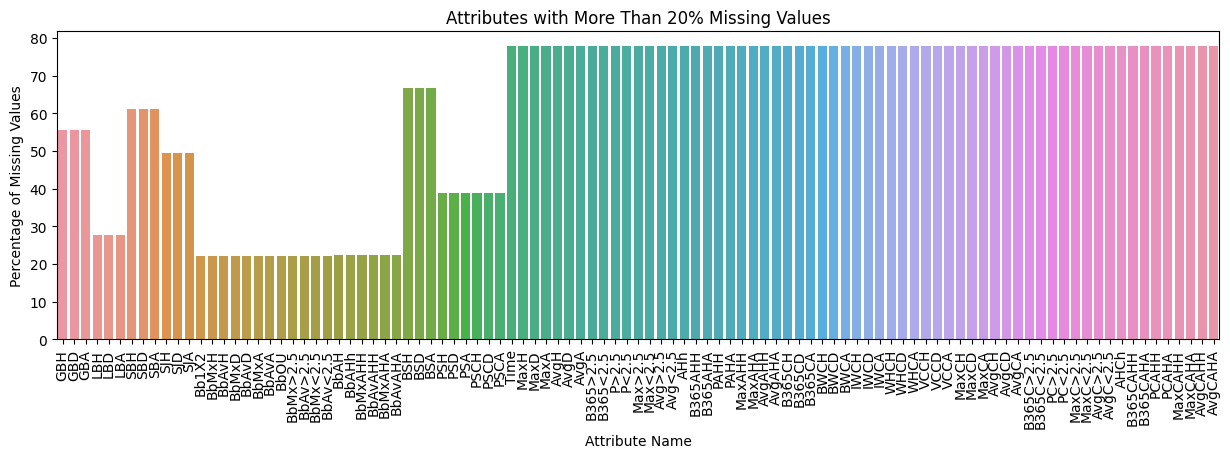

In [5]:
# Identify the columns with high percentagve of missing values
high_missing_value_cols = missing_values_percent[missing_values_percent > 20].index.tolist()

# Vislaise columns with high percentage of missing values
plt.figure(figsize=(15, 4))
sns.barplot(x=high_missing_value_cols, y=missing_values_percent[high_missing_value_cols ])
plt.xticks(rotation=90)
plt.xlabel('Attribute Name')
plt.ylabel('Percentage of Missing Values')
plt.title('Attributes with More Than 20% Missing Values')
plt.show()

It is evident that a substantial portion of the dataset has columns with over 20% missing data. Predominantly, these columns correspond to betting odds provided by various bookmakers. A notable exception is the `Time` attribute, which specifies the kickoff time of matches.

Considering the focus of this analysis, the columns related to betting odds will be excluded. The significant missing data in these columns suggets a variation in the collection of betting odds information across different seasons. Since betting odds are not central to this analysis,. they will be omitted to maintain the relevance and clarity of the dataset.

To gain a deeper understanding of the impact of missing values in the `Time` attribute, a detailed analysis has been conducted to identify the seasons most affects by this issue. This investigation aims to determine the distribution of missing data across seasons, whether the absence of `Time` data is consistent or if certain seasons are more susceptible to gaps.

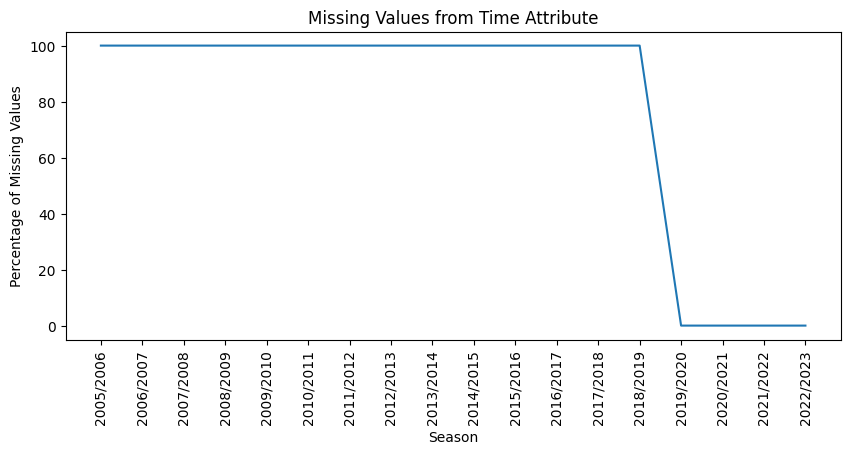

In [6]:
# Stage 'Time' feature for analysis across different seasons
missing_values_time_by_season = df['Time'].isnull().groupby(df['Season']).mean() * 100

# Plot the missing values of the 'Time' attribute across all seasons
plt.figure(figsize=(10, 4))
sns.lineplot(data=missing_values_time_by_season, x=missing_values_time_by_season.index, y=missing_values_time_by_season)
plt.xlabel('Season')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values from Time Attribute')
plt.xticks(rotation=90)
plt.show()

The above visual clearly indicates that the `Time` attribute, which records match kick-off times, was only recorded from 2019/20 season. Due to its significant absence in the majority of seasons, it will be excluded from the dataset to maintain data integrity and relevance.

Consdiering the comprehensive nature of the dataset, not all columns are deemed essential for the predictive model, which focuses on pre-match information. Therefore, a set of critical columns has been identified, with their completeness being crucial to the analysis and predictive modelling. These critical columns have been carefully selected based on their potential impact on the analysis. To ensure the integrity and reliability of the dataset, rows with missing values in these critical columns have been removed. This approach strikes a balance between preserving as much data as possible while ensuring that the remaining dataset is robust and suitable for accurate predictive modelling.

The critical columns have been summarised below:
- `Date`: Match Date (dd/mm/yy)
- `Home Team`: Home Team
- `Away Team`: Away Team
- `FTR`: Full Time Result (H=Home Win, D=Draw, A=Away Win). **Target Attribute**.

Note: Although the following attributes are not pre-match information, they have been included for the intial analysis and to support feature engineering.
- `FTHG`: Full Time Home Team Goals
- `FTAG`: Full Time Away Team Goals

The following section analyses the extent of the missing values in the selected features.

In [7]:
# Define the critical columns for analysis
critical_cols = ['Date', 'Season', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Referee', 'FTR']

# Calculate the number of missing values in each critical column
missing_values_critical = df[critical_cols].isnull().sum()

# Convert the Series to a DataFrame
missing_values_critical_table = pd.DataFrame(missing_values_critical).reset_index()
missing_values_critical_table.columns = ['Column', 'Missing Values']

# Display the table
missing_values_critical_table

,Column,Missing Values
0,Date,1
1,Season,0
2,HomeTeam,1
3,AwayTeam,1
4,FTHG,1
5,FTAG,1
6,Referee,1
7,FTR,1


The specific rows affected by the missing values are captured below.

In [8]:
# Missing values from critical columns
rows_with_missing_values = df[df[critical_cols].isnull().any(axis=1)]

rows_with_missing_values

,Unnamed: 0,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
3800,3800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These missing values have been exlcuded from the dataset

In [9]:
# Remove rows missing values in the defined critical columns
cleaned_df = df[critical_cols]
cleaned_df = cleaned_df.dropna(subset=critical_cols)


# Validate no missing values occur in the critical columns
missing_values_cleanup = cleaned_df.isnull().sum()
missing_values_cleanup

Date        0
Season      0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
Referee     0
FTR         0
dtype: int64

In [10]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6840 entries, 0 to 6840
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      6840 non-null   object 
 1   Season    6840 non-null   object 
 2   HomeTeam  6840 non-null   object 
 3   AwayTeam  6840 non-null   object 
 4   FTHG      6840 non-null   float64
 5   FTAG      6840 non-null   float64
 6   Referee   6840 non-null   object 
 7   FTR       6840 non-null   object 
dtypes: float64(2), object(6)
memory usage: 480.9+ KB


In [11]:
# Convert Date to datetime
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'], dayfirst=True)

# Sort the DataFrame by the Date column
cleaned_df.sort_values('Date', inplace=True)

# Function to map FTR values to numeric values
def encode_ftr(value):
    if value == 'H':
        return 0
    elif value == 'D':
        return 1
    elif value == 'A':
        return 2
    else:
        return None

# Apply the function to the FTR column
cleaned_df['FTR_encoded'] = cleaned_df['FTR'].apply(encode_ftr)

cleaned_df.head()

,Date,Season,HomeTeam,AwayTeam,FTHG,FTAG,Referee,FTR,FTR_encoded
0,2005-08-13,2005/2006,Aston Villa,Bolton,2.0,2.0,M Riley,D,1
1,2005-08-13,2005/2006,Everton,Man United,0.0,2.0,G Poll,A,2
2,2005-08-13,2005/2006,Fulham,Birmingham,0.0,0.0,R Styles,D,1
3,2005-08-13,2005/2006,Man City,West Brom,0.0,0.0,C Foy,D,1
4,2005-08-13,2005/2006,Middlesbrough,Liverpool,0.0,0.0,M Halsey,D,1


## Feature Engineering

The objective of this section is to enhance and refine the dataset to unlock deeper insights and augment its predictive potential. These enhancements are crucial for developing robust predictive models and generating accruate forecast. This process involve not only adding new calculated metrics but also ensuring the data's consistency and relevance. 

`Rolling Average Home Goals`: This attribute calculates the rolling average of goals scored by each home team over their last give home matches. It serves as a dynamic measure of the team's offensive performance in their home games, providing insights into their scoring consistency and effectiveness in familiar conditions. By using a rolling window of five matches, this metric offers a current and fluid assessment of each team's goal-scoring prowess in front of their home crowd. This is especially useful for indetifying trends in attacking strength and potential shifts in tactical approaches at home games.

In [12]:
# The rolling average of goals scored by home teams in the last 5 matches
cleaned_df['RollingAvgHomeGoals'] = cleaned_df.groupby('HomeTeam')['FTHG'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

`Home Win Ratio`: This metric calculates the rolling average of home wins for each home team across the last five games. It reflects the recent home game performance of each team, providing insight into thei short-term success in home matches. By focusing on the most recent five games, it offers a current perspective on each team's home field advantage and winning consistency at their own venue.

`Away Win Ratio`: Similiarly, this attribute represents the rolling average of away wins for each away team over their last five away games. It serves as an indicator of how well teams perform when playing outside their home stadium, highlighting their abilioty to secure victories in potentially challenging away environments. This measure is particularly useful for assessing a team's resilience and adaptabilityt in different venues.

In [13]:
# Home wins represented as a nuneric value
cleaned_df['HomeWin'] = cleaned_df['FTR'].apply(lambda x: 1 if x == 'H' else 0)

# Away wins represented as a nuneric value
cleaned_df['AwayWin'] = cleaned_df['FTR'].apply(lambda x: 1 if x == 'A' else 0)

# Home win rolling average
cleaned_df['HomeWinRatio'] = cleaned_df.groupby('HomeTeam')['HomeWin'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

# Away win rolling average
cleaned_df['AwayWinRatio'] = cleaned_df.groupby('AwayTeam')['AwayWin'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

`Home Win Percentage`: Represents the historical win percentage of the home team in a specific matchup based on past games. A higher values indicates a higher likelihood of the home team winning in that specific matchup, while a lower value suggests a lower likelihood of winning. This attribute helps analyse the historical performance of the home team against the given oppenent.

In [14]:
#Create a matchup identifier
def create_matchup_identifier(row):
    return f"{row['HomeTeam']}_vs_{row['AwayTeam']}"

# Create a matchup column
cleaned_df['Matchup'] = cleaned_df.apply(create_matchup_identifier, axis=1)

# Calculate win percentage for the home team in this specific matchup
def calculate_win_percentage(data, current_matchup, current_date):
    past_matches = data[(data['Matchup'] == current_matchup) & (data['Date'] < current_date)]
    if len(past_matches) == 0:
        return 0.5  # Default value if no past matches

    # Count how many times the home team has won specific matchup
    wins = (past_matches['FTR'] == 'H').sum()
    return wins / len(past_matches) if len(past_matches) > 0 else 0.5

# Create home win percent column
cleaned_df['HomeWinPercentage'] = cleaned_df.apply(lambda row: calculate_win_percentage(cleaned_df, row['Matchup'], row['Date']), axis=1)

`Home Last Five Score`: Respresents the rolling sum of the last five match outcomes scores for the home teams, where a win = 1, draw = 0 and a loss = -1. This attribute provides insight into the recent performance trend of the home team by summing up their match results over the last 5 games.

`Away Last Five Score`: Similiarly, it respresents the rolling sum of the last five match outcomes scores for the away teams, where a win = 1, draw = 0 and a loss = -1. This attribute provides insight into the recent performance trend of the away team by summing up their match results over the last 5 games.

In [15]:
# Calculating the rolling sum of the last five match outcome scores for home teams
cleaned_df.loc[:, 'HomeLastFiveScore'] = cleaned_df.groupby('HomeTeam')['FTR_encoded'].transform(lambda x: x.rolling(window=5, min_periods=1).sum())

# Calculating the rolling sum of the last five match outcome scores for away teams
cleaned_df.loc[:, 'AwayLastFiveScore'] = cleaned_df.groupby('AwayTeam')['FTR_encoded'].transform(lambda x: x.rolling(window=5, min_periods=1).sum() * -1)

## Exploratory Data Analysis

### Season Trends

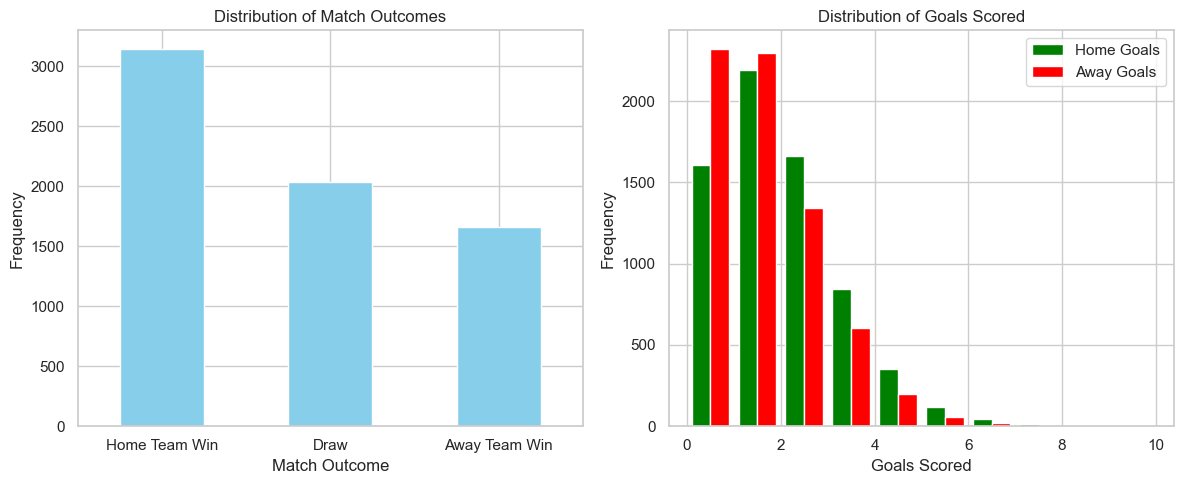

In [16]:
sns.set(style="whitegrid")

# Distribution of the match outcome
outcome_counts = cleaned_df['FTR'].value_counts()

# Goals scored distribution
goals_home = cleaned_df['FTHG']
goals_away = cleaned_df['FTAG']

# Create plots
plt.figure(figsize=(12, 5))

# Plot match outcome distribution
plt.subplot(1, 2, 1)
outcome_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Match Outcomes')
plt.xlabel('Match Outcome')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['Home Team Win', 'Draw', 'Away Team Win'], rotation=0)

# Plot goals scored distribution
plt.subplot(1, 2, 2)
plt.hist([goals_home, goals_away], bins=range(0, 11), color=['green', 'red'], label=['Home Goals', 'Away Goals'])
plt.title('Distribution of Goals Scored')
plt.xlabel('Goals Scored')
plt.ylabel('Frequency')
plt.legend()

# Display plots
plt.tight_layout()
plt.show()


The bar charts show the distribution of match outcomes and goals scored in a football dataset. The left chart indicates home teams win more frequently than away teams, with draws being less common. The right chart displays goals scored, with home teams (green) scoring more frequently than away teams (red), especially one or two goals per match. High-scoring games (more than 4 goals) are less common. 

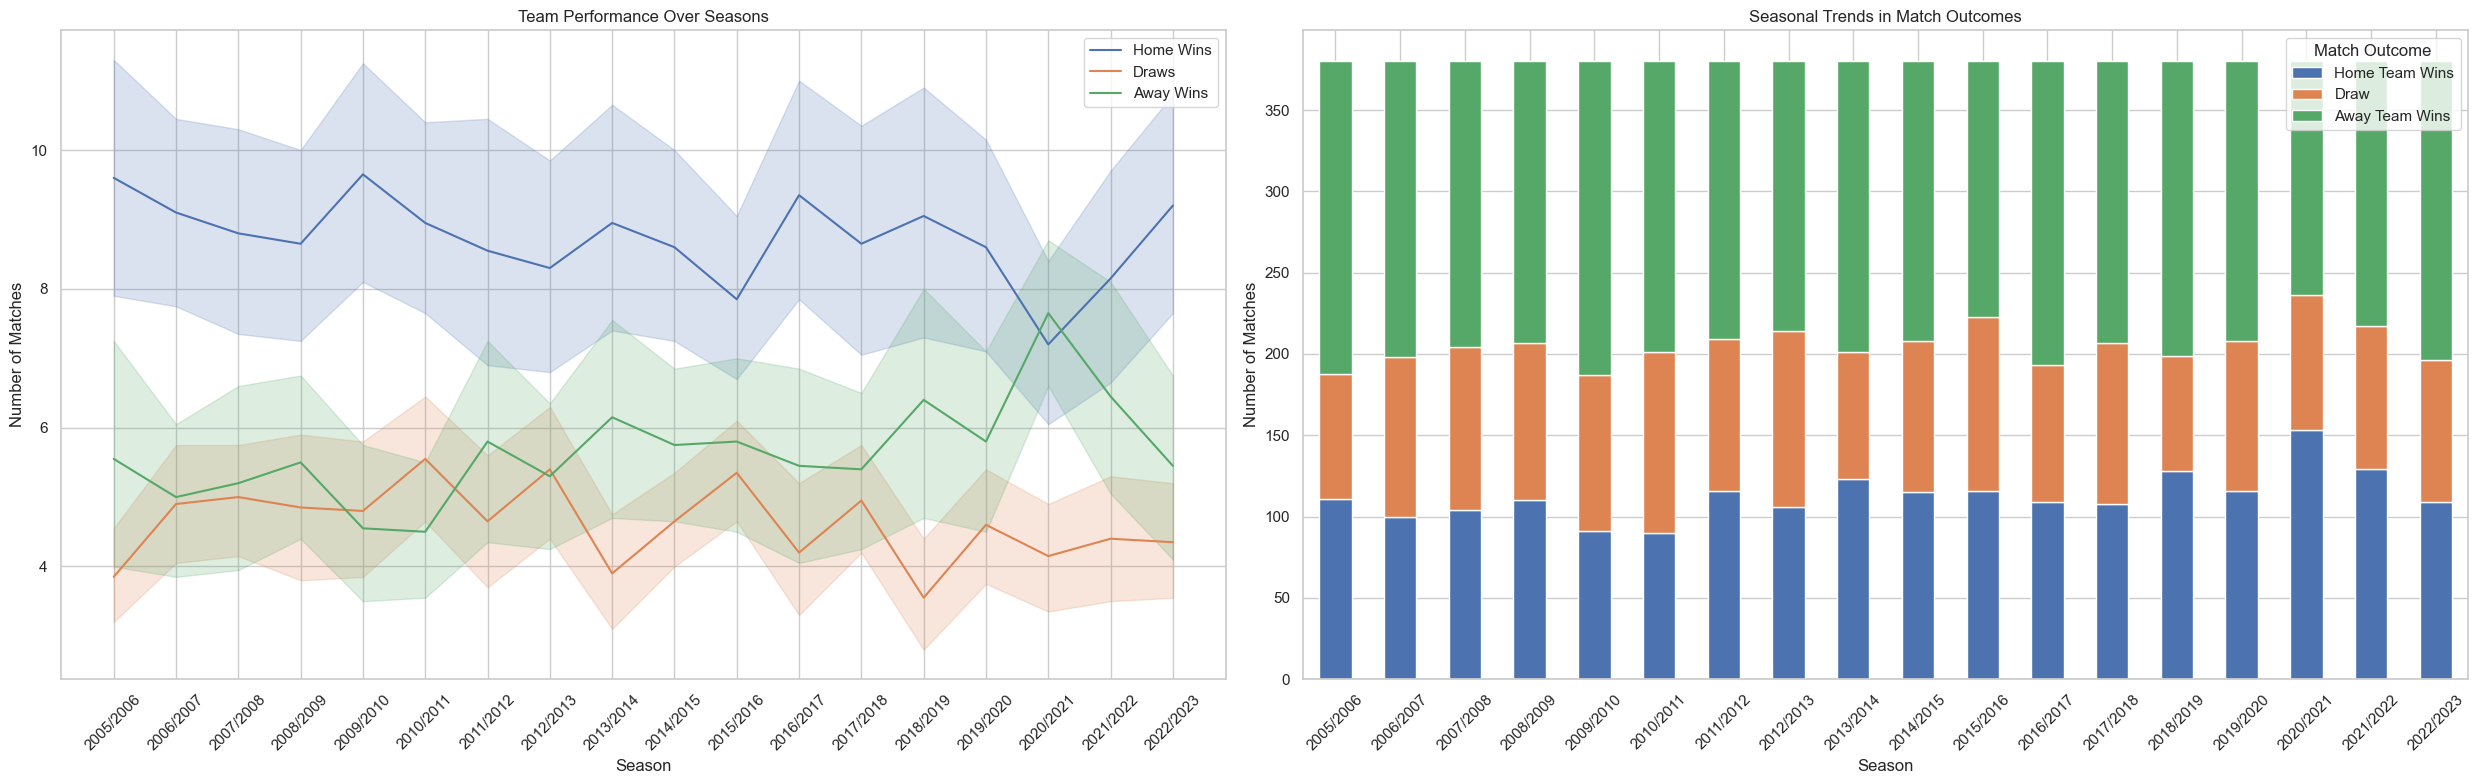

In [17]:
# Team performance by season
team_performance = cleaned_df.groupby(['Season', 'HomeTeam']).agg({'FTR': ['count', lambda x: (x == 'H').sum(), lambda x: (x == 'D').sum(), lambda x: (x == 'A').sum()]})
team_performance.columns = ['TotalMatches', 'HomeWins', 'Draws', 'AwayWins']
team_performance = team_performance.reset_index()

# Season trend analysis
seasonal_trends = cleaned_df.groupby(['Season', 'FTR']).size().unstack().fillna(0)

# Create subplots
plt.figure(figsize=(25, 8))

# Team performance over seasons
plt.subplot(1, 2, 1)
sns.lineplot(data=team_performance, x='Season', y='HomeWins', label='Home Wins')
sns.lineplot(data=team_performance, x='Season', y='Draws', label='Draws')
sns.lineplot(data=team_performance, x='Season', y='AwayWins', label='Away Wins')
plt.xticks(rotation=45)
plt.title('Team Performance Over Seasons')
plt.ylabel('Number of Matches')
plt.xlabel('Season')
plt.legend()

# Seasonal trends in match outcomes
plt.subplot(1, 2, 2)
seasonal_trends.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Seasonal Trends in Match Outcomes')
plt.xlabel('Season')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45)
plt.legend(title='Match Outcome', labels=['Home Team Wins', 'Draw', 'Away Team Wins'])

# Display plots
plt.tight_layout()
plt.show()


The visualisations depict team performance over seasons in a football league. The first graph shows fluctuations in the number of matches won at home, drawn, and won away by season, with home wins generally higher. The second graph illustrates the seasonal trends in match outcomes, consistently showing home teams win more often than away teams, with the number of draws being the least frequent outcome. Both graphs indicate a strong home advantage and could suggest strategies for teams to improve away performance or capitalise on home games.

### Team Performances

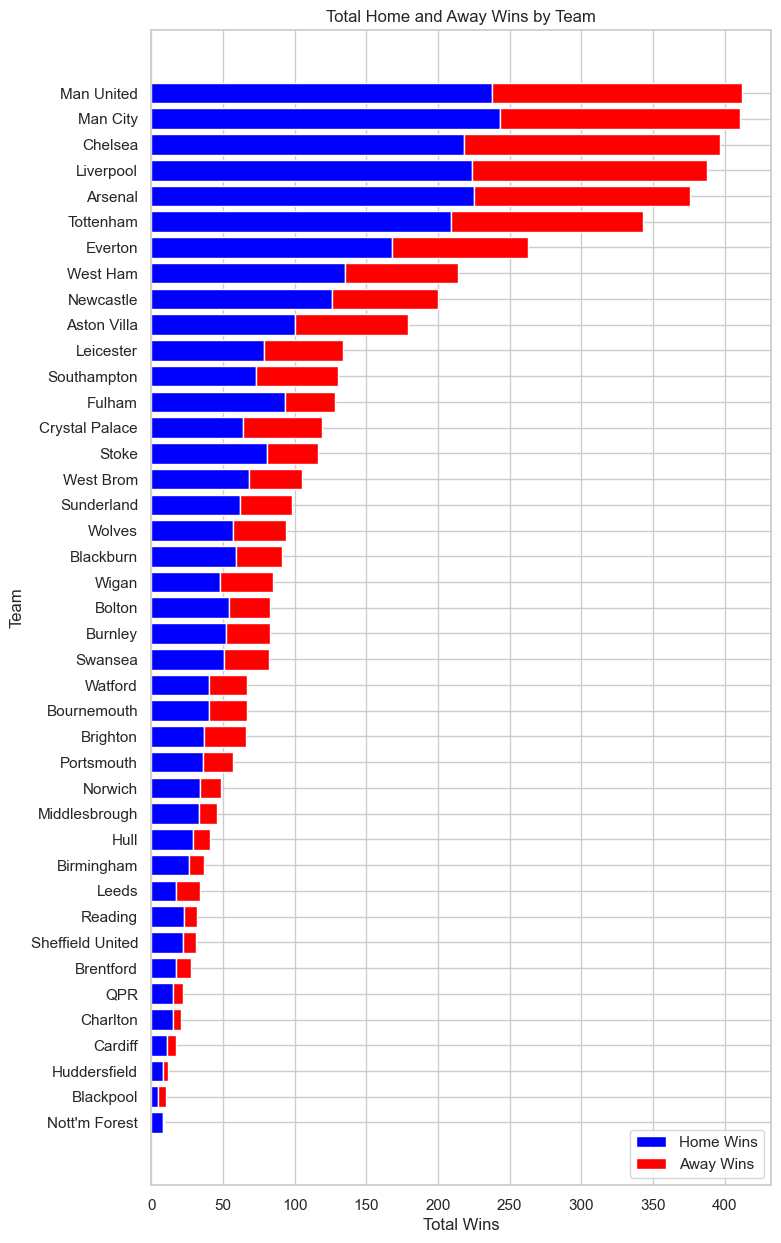

In [18]:
# Total home wins by team
total_home_wins = cleaned_df[cleaned_df['FTR'] == 'H'].groupby('HomeTeam')['FTR'].count()

# Total away wins by team
total_away_wins = cleaned_df[cleaned_df['FTR'] == 'A'].groupby('AwayTeam')['FTR'].count()

# Convert the Series to DataFrames
df_total_home_wins = total_home_wins.reset_index()
df_total_home_wins.columns = ['Team', 'Home Wins']

df_total_away_wins = total_away_wins.reset_index()
df_total_away_wins.columns = ['Team', 'Away Wins']

# Merge the two dataframes for a combined view
df_total_wins = pd.merge(df_total_home_wins, df_total_away_wins, on='Team')

# Add column for total wins
df_total_wins['Total Wins'] = df_total_wins['Home Wins'] + df_total_wins['Away Wins']

# Sort the DataFrame by 'Total Wins'
df_total_wins_sorted = df_total_wins.sort_values('Total Wins', ascending=True)

# Plot the visual
plt.figure(figsize=(8, 15))
plt.barh(df_total_wins_sorted['Team'], df_total_wins_sorted['Home Wins'], color='blue', label='Home Wins')
plt.barh(df_total_wins_sorted['Team'], df_total_wins_sorted['Away Wins'], left=df_total_wins_sorted['Home Wins'], color='red', label='Away Wins')
plt.ylabel('Team')
plt.xlabel('Total Wins')
plt.title('Total Home and Away Wins by Team')
plt.legend()
plt.show()

The bar chart shows the total number of home (blue) and away (red) wins for football teams. Manchester United leads with the highest number of home wins, while Manchester City has the most away wins. The chart reflects a common trend in football, where teams tend to win more games at home than away. Lower-ranked teams like Nottingham Forest have significantly fewer wins, both home and away, indicating their struggles in the league. 

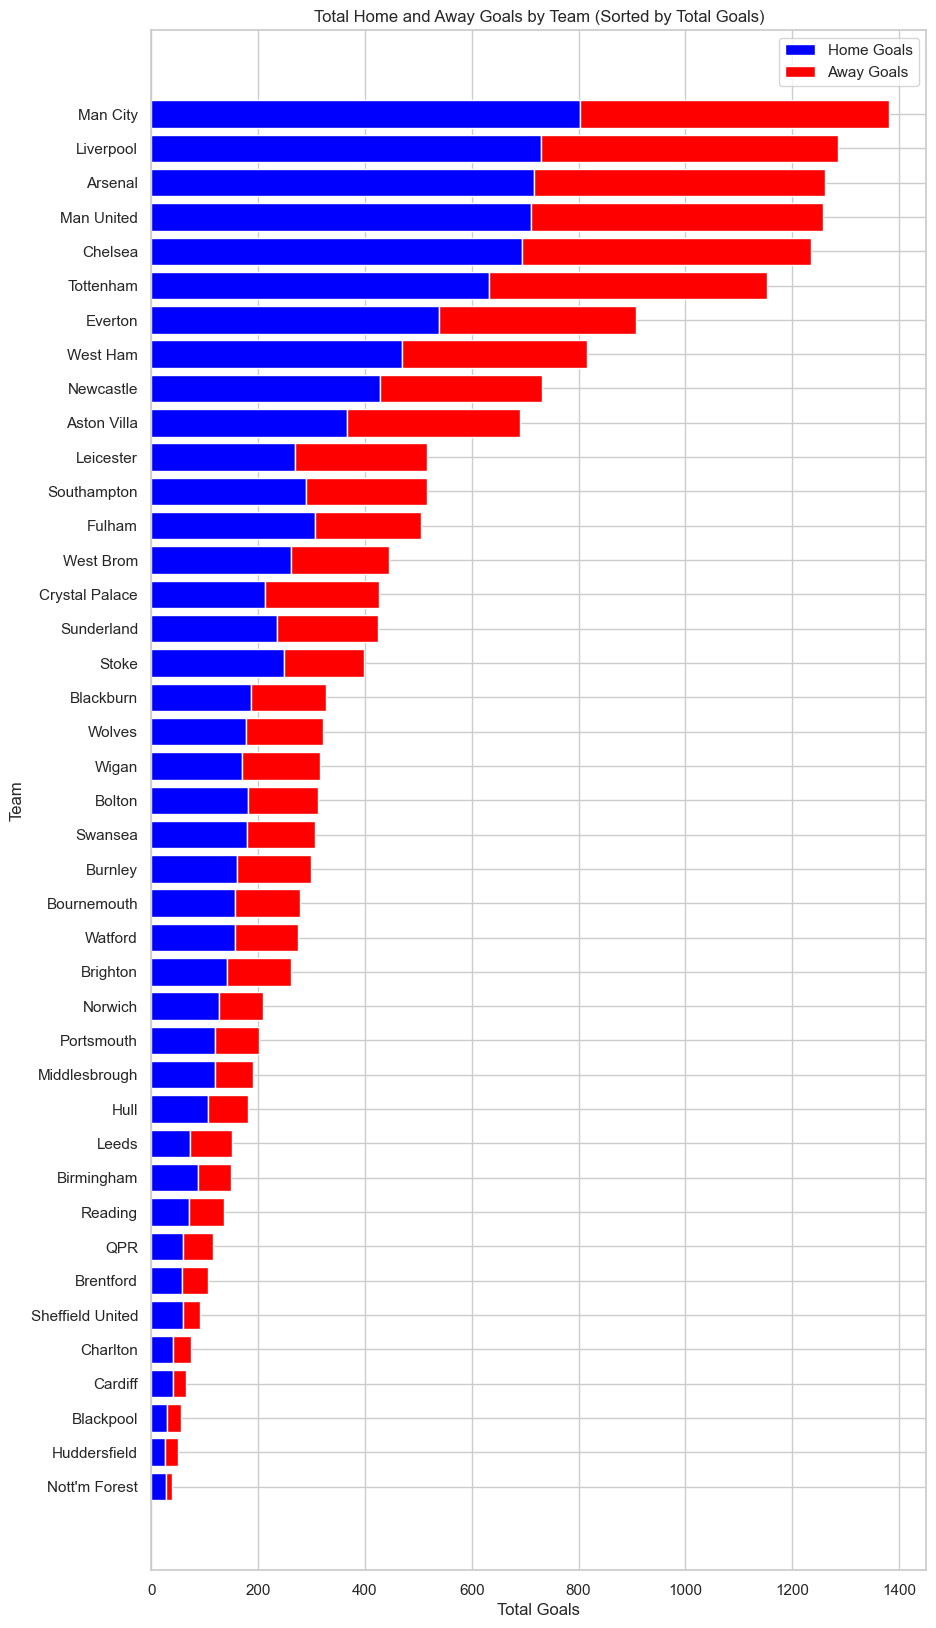

In [19]:
# Total home goals by team
total_home_goals = cleaned_df.groupby('HomeTeam')['FTHG'].sum()

# Total away goals by team
total_away_goals = cleaned_df.groupby('AwayTeam')['FTAG'].sum()

# Convert the Series to DataFrames
df_total_home_goals = total_home_goals.reset_index()
df_total_home_goals.columns = ['Team', 'Home Goals']

df_total_away_goals = total_away_goals.reset_index()
df_total_away_goals.columns = ['Team', 'Away Goals']

# Merge dataframes for a combined view
df_total_goals = pd.merge(df_total_home_goals, df_total_away_goals, on='Team')

# Add total wins for correlation plot
df_total_goals = pd.merge(df_total_goals, df_total_wins[['Team', 'Total Wins']], on='Team')

# Add column for total goals
df_total_goals['Total Goals'] = df_total_goals['Home Goals'] + df_total_goals['Away Goals']

# Sort DataFrame by 'Total Goals'
df_total_goals_sorted = df_total_goals.sort_values('Total Goals', ascending=True)


# Plot visual
plt.figure(figsize=(10, 20))
plt.barh(df_total_goals_sorted['Team'], df_total_goals_sorted['Home Goals'], color='blue', label='Home Goals')
plt.barh(df_total_goals_sorted['Team'], df_total_goals_sorted['Away Goals'], left=df_total_goals_sorted['Home Goals'], color='red', label='Away Goals')
plt.ylabel('Team')
plt.xlabel('Total Goals')
plt.title('Total Home and Away Goals by Team (Sorted by Total Goals)')
plt.legend()
plt.show()



The bar chart compares the total home (blue) and away (red) goals scored by football teams. Teams are sorted by their total goals scored, both home and away. Top teams like Manchester City and Liverpool have scored a significantly higher number of goals, especially at home. The chart shows that most teams have scored more home goals than away, which is common in football due to home advantage. Teams at the bottom, like Huddersfield and Nottingham Forest, have scored fewer goals overall, indicating they might struggle offensively both at home and away.

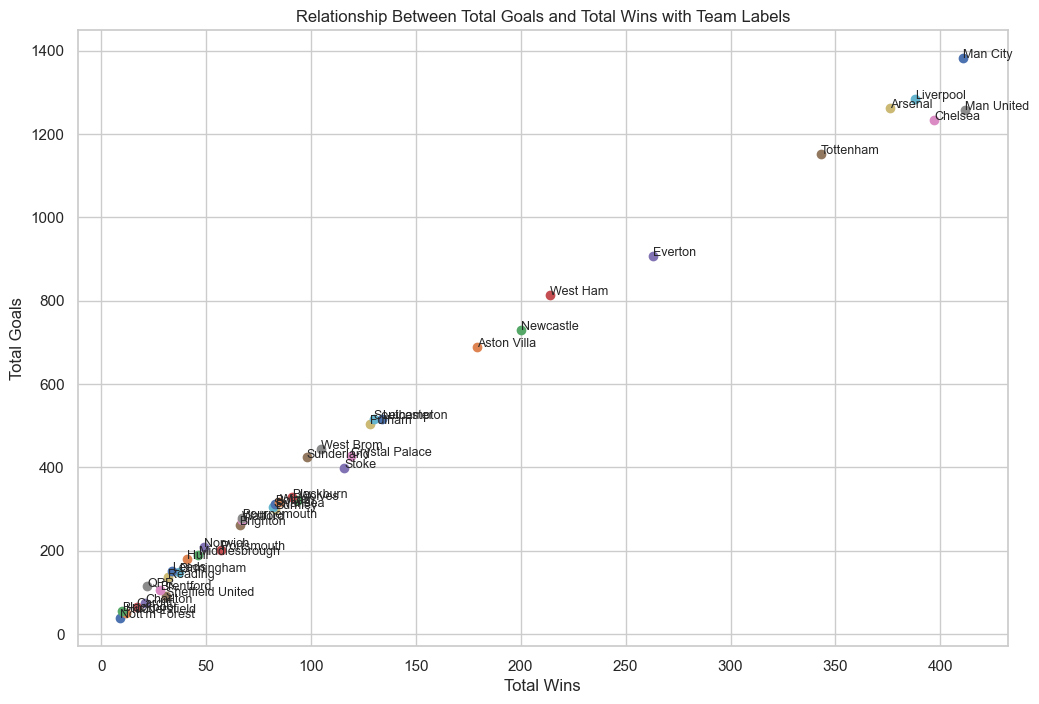

In [20]:
plt.figure(figsize=(12, 8))

# Plotting each point and adding a label for the team
for index, row in df_total_goals_sorted.iterrows():
    plt.scatter(row['Total Wins'], row['Total Goals'])
    plt.text(row['Total Wins'], row['Total Goals'], row['Team'], fontsize=9)

plt.xlabel('Total Wins')
plt.ylabel('Total Goals')
plt.title('Relationship Between Total Goals and Total Wins with Team Labels')
plt.show()

The scatter plot depicts the relationship between total goals and total wins for various football teams. Teams like Manchester City, Liverpool, Arsenal, Manchester United, and Chelsea are located in the upper right quadrant, indicating a high number of total goals and wins, suggesting successful performance. Teams like Aston Villa and Newcastle are in the mid-range for both metrics. Clubs in the bottom left, like Norwich and Birmingham, have fewer total goals and wins, which could indicate less success on the pitch. Overall, there seems to be a positive correlation between scoring goals and winning matches.

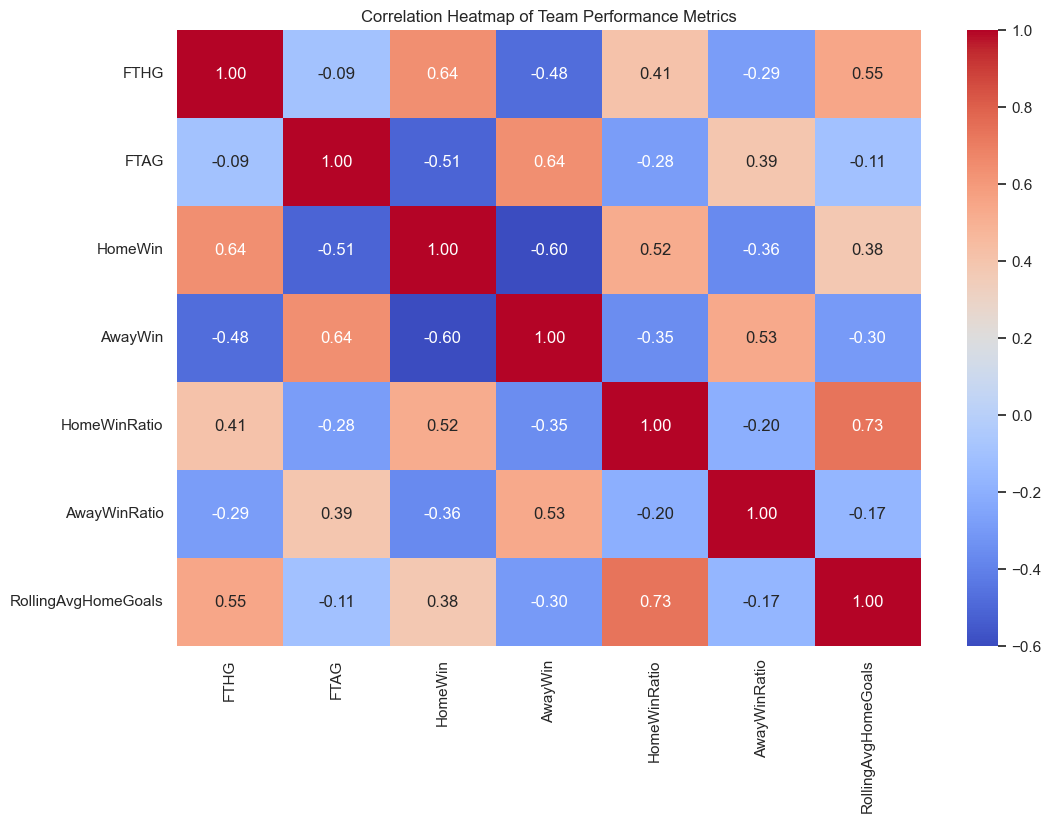

In [21]:
# Select relevant numeric columns for correlation analysis
numeric_cols = ['FTHG', 'FTAG', 'HomeWin', 'AwayWin', 'HomeWinRatio', 'AwayWinRatio', 'RollingAvgHomeGoals']
correlation_df = cleaned_df[numeric_cols]

# Correlation matrix
corr_matrix = correlation_df.corr()

# Generate heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Team Performance Metrics')
plt.show()


**Key Observations**
- `Full-Time Home Goals (FTHG)` have a strong positive correlation with `HomeWin`, implying that more goals scored by the home team often result in a win.
- `Full-Time Away Goals (FTAG)` have a strong positive correlation with `AwayWin`, suggesting that away goals are indicative of away team victories.
- There is a strong negative correlation between `HomeWin` and `AwayWin`, which is expected as only one team can win a match.
- `HomeWinRatio` and `AwayWinRatio` show strong positive correlations with their respective win conditions (HomeWin and AwayWin), indicating their predictive value.
- `RollingAvgHomeGoals` is more correlated with `FTHG` compared to `FTAG`, suggesting home goals are more consistent with the rolling average.

## Modelling

In the following section three models have been explored to predict the match outcomes of EPL fixtures. These models include:
1. Logistic Regression
2. Random Forest
3. Support Vector Machines

Each model's performance has been assessed and the key contributing features have also been analysed. 

In [22]:
# Final dataset for modelling

features = ['Matchup', 'RollingAvgHomeGoals', 'HomeWinRatio', 'AwayWinRatio', 'Referee', 'FTR_encoded', 'HomeWinPercentage', 'HomeLastFiveScore', 'AwayLastFiveScore']
final_dataset = cleaned_df[features]

final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6840 entries, 0 to 6840
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Matchup              6840 non-null   object 
 1   RollingAvgHomeGoals  6840 non-null   float64
 2   HomeWinRatio         6840 non-null   float64
 3   AwayWinRatio         6840 non-null   float64
 4   Referee              6840 non-null   object 
 5   FTR_encoded          6840 non-null   int64  
 6   HomeWinPercentage    6840 non-null   float64
 7   HomeLastFiveScore    6840 non-null   float64
 8   AwayLastFiveScore    6840 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 534.4+ KB


The following section contains the preprocessing steps prior to training the individual models

In [23]:
# Preparing the data
X = final_dataset.drop('FTR_encoded', axis=1)  # Features
y = final_dataset['FTR_encoded']  # Target

# List of columns to label encode
categorical_cols = ['Matchup', 'Referee']

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Loop through the specified columns and apply label encoding
for column in categorical_cols:
    X[column] = label_encoder.fit_transform(X[column])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardise the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Model

In [24]:
# Create the base LR model
log_reg = LogisticRegression(random_state=1)

# Parameter grid for LR model
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

# Instantiate the grid search
lr_grid_search = GridSearchCV(estimator=log_reg, param_grid=lr_param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
lr_grid_search.fit(X_train, y_train)

# Return the best parameters identified
print("Best parameters found: ", lr_grid_search.best_params_)

# Create the best model
best_lr_model = lr_grid_search.best_estimator_

# Use model for predictions on test set
lr_y_pred = best_lr_model.predict(X_test)

# Evaluate the model on the test set
print("Test Set Accuracy:", accuracy_score(y_test, lr_y_pred))
print("\nTest Set Classification Report:\n", classification_report(y_test, lr_y_pred))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


Best parameters found:  {'C': 10, 'solver': 'newton-cg'}
Test Set Accuracy: 0.7412280701754386

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80       642
           1       0.71      0.58      0.64       344
           2       0.71      0.75      0.73       382

    accuracy                           0.74      1368
   macro avg       0.73      0.72      0.72      1368
weighted avg       0.74      0.74      0.74      1368



**Class 0 (Home Team Win) Performance**

- Class 0 has the highest precision (0.77) among the three classes, meaning that when the model predicts an instance as Class 0, it is correct 77% of the time.
- This class also has the highest recall (0.82), indicating that it correctly identifies 82% of all actual Class 0 instances.
- The F1-score is also highest for Class 0 at 0.80, suggesting a balanced classification performance for this class.

**Class 1 (Draw) Performance**

- Class 1 has a lower recall of 0.58, indicating that the model misses a significant portion (42%) of the actual Class 1 instances.
- Despite having a reasonable precision of 0.71, the lower recall impacts the F1-score, which is the lowest among all classes at 0.64.
- This suggests that the model's ability to correctly identify Class 1 instances could be improved.

**Class 2 (Away Team Win) Performance**

- Class 2's performance is intermediate between Class 0 and Class 1, with a precision of 0.71 and a recall of 0.75.
- The F1-score for Class 2 is 0.73, indicating relatively good classification performance, although there is room for improvement, especially in increasing precision.

**Overall Model Performance**

- The overall accuracy of the model is 0.74, which means that it correctly predicts the class for approximately 74% of the instances across the test set.

#### Confusion Matrix

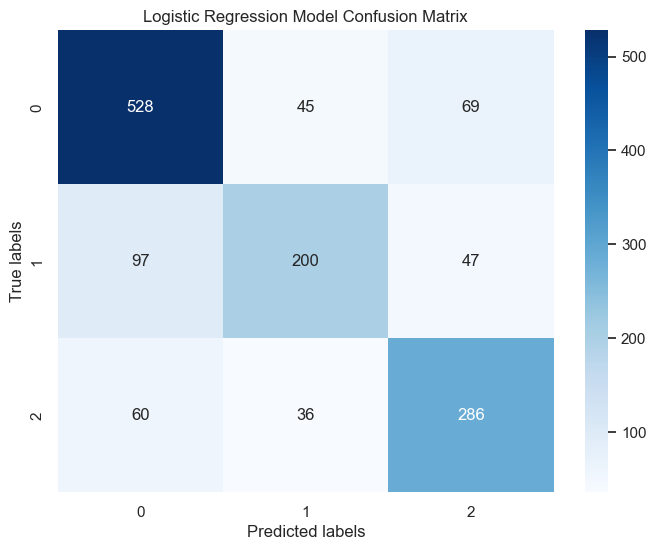

In [25]:
classes=[0, 1, 2]

# Create confusion matrix for LR model
conf_matrix = confusion_matrix(y_test, lr_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Logistic Regression Model Confusion Matrix')
plt.show()

- Class 0 (Home Wins) has the highest number of correct predictions, suggesting the model is most accurate for this class. 
- There appears to be some confusion between class 0 (Home Wins) and other classes, as indicated by the relatively higher false negatives for class 0 (Home Wins).
- Class 1 (Draw) has the lowest number of correct predictions, suggesting this outcome is the hardest to predict.
- The relatively balanced false positve and false negatiev rates for class 1 (Draw) and Class 2 (Away Team Win) suggest the model does not exhibit a strong bias towards one class over the other.

#### ROC Curves

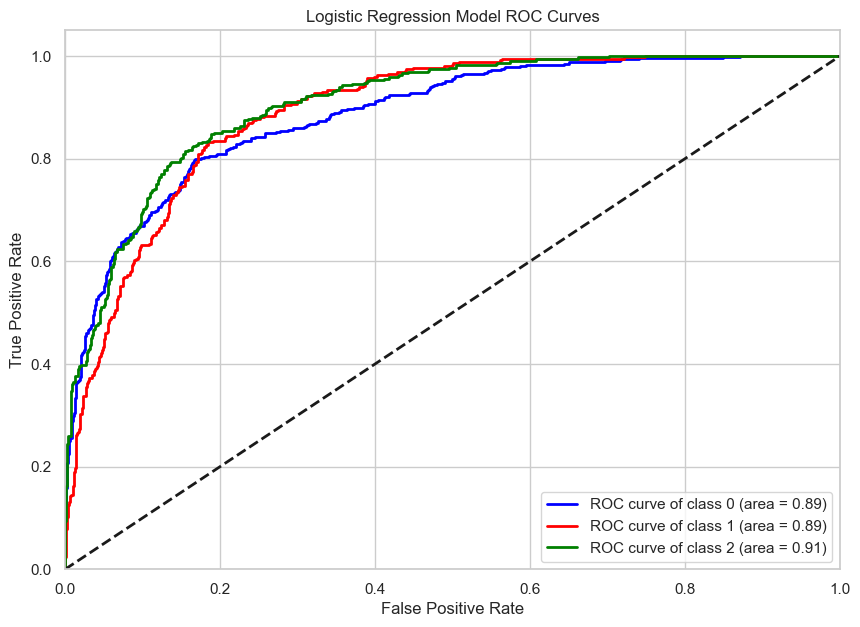

In [26]:
# Convert output labels to binary labels for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Create ROC curve for each class for the LR model
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    y_probs = best_lr_model.predict_proba(X_test)[:, i]
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves for the LR model
plt.figure(figsize=(10, 7))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Model ROC Curves')
plt.legend(loc="lower right")
plt.show()


- Each class has a ROC curve that is significantly above the diagonal line, indicating that the model has a good ability to differentiate between the positive class and the negative classes for all categories.
- Class 2 (Away Team Win) has the highest Area Under Curve (AUC) of 0.91, suggesting that the model is best at distiguishing class 2 (Away Team Wins) from the others.
- Class 0 (Home Team Win) and Class 1 (Draw) have lower AUCs at 0.89, however this is still a relatively good performance but indicates a slightly lower discriminative ability for these classes.

#### LR Model's Performance Summary

The relatively lower recall for Class 1 (Draw) in the classification report supports the observation from the ROC Curve that Class 1 (Draw) is more challenging for the model to predict accurately. The high AUC for Class 2 indicates the model has strong ability to rank Class 2 (Away Win) higher than the other classes, but the recall indicates that the chosen threshold may not be optimal for capturing all true Class 2 (Draw) instances. The overall accuracy of the model 0.74, which is a moderate performance, but there still room for improvement, especially correctly identifying Class 1(Draw) instances.

#### Key Contributors

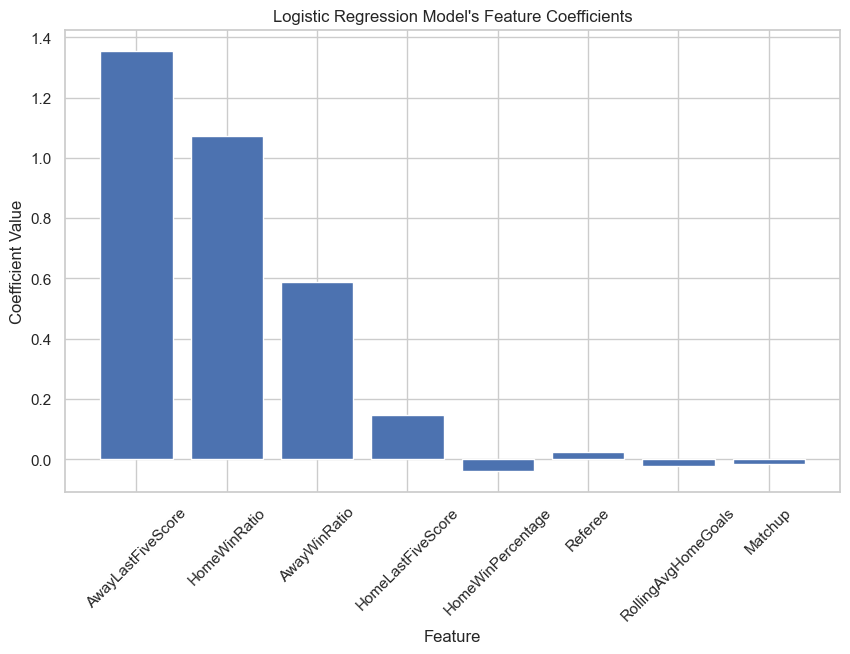

In [27]:
# Feature names
feature_names = ['Matchup', 'RollingAvgHomeGoals', 'HomeWinRatio', 'AwayWinRatio', 'Referee', 'HomeWinPercentage', 'HomeLastFiveScore', 'AwayLastFiveScore']

# Determine coefficients for each feature
coefficients = best_lr_model.coef_[0]

# Create DataFrame to store coefficients
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by absolute coefficient values in descending order
importance_df = importance_df.reindex(importance_df['Coefficient'].abs().sort_values(ascending=False).index)

# Plot the top features
no_features = len(feature_names)
plt.figure(figsize=(10, 6))
plt.bar(range(no_features), importance_df['Coefficient'][:no_features])
plt.xticks(range(no_features), importance_df['Feature'][:no_features], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Model\'s Feature Coefficients'.format(no_features))
plt.show()

- The `AwayLastFiveScore` feature has the highest coefficient value, which suggests that it is the most significant predictor in the model, and a higher score for this attribute is assoicated with a stronger prediction for the target class.
- The `HomeWinRatio` is the second most influencial feature, indicating that home teams's win ratio is a strong indicator of the outcome.
- `HomeWinPercentage` had the highest negative coefficient indicating that higher values in this feature decreases the liklihood of the instance being predicted in the target class.

**Potential Model Improvement**

Low-impact features could be reassessed to see if they can be transformed to better capture the predictive signal.

### Random Forest Model

In [28]:
# RF parameter grid definitions
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the random forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Initialise the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=1)

# Initialise GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the RF grid search to the data
rf_grid_search.fit(X_train, y_train)

# Best RF parameters
print("Best Parameters: ", rf_grid_search.best_params_)

# Use the best model
best_rf_model = rf_grid_search.best_estimator_

# Make predictions with the best RF model
rf_y_pred = best_rf_model.predict(X_test)

# Evaluating the RF model
print("Accuracy:", accuracy_score(y_test, rf_y_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_y_pred))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.7178362573099415

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       642
           1       0.68      0.50      0.58       344
           2       0.66      0.75      0.70       382

    accuracy                           0.72      1368
   macro avg       0.70      0.69      0.69      1368
weighted avg       0.72      0.72      0.71      1368



**Class 0 (Home Team Win) Performamce**

- The precision for Class 0 is relatively high at 0.76, indicating that when the model predicts an instance as Class 0, it is correct approximately 76% of the time.
- The recall for Class 0 is the highest among all classes at 0.82, showing that the model is able to identify 82% of all actual Class 0 instances correctly.
- The F1-score is relatively good at 0.79, making it the best-performing class in terms of F1-score.

**Class 1 (Draw) Performamce**

- Class 1 has a lower precision of 0.68, suggesting that there is a higher chance of false positives for this class compared to Class 0.
- The recall for Class 1 is 0.50, which is the lowest among the classes. This means the model is only able to correctly identify half of the actual instances of Class 1.
- The F1-score for Class 1 is 0.58, indicating there is significant room for improvement, particularly in terms of improving recall.

**Class 2 (Away Team Win) Performamce**

- Class 2 has a precision of 0.66, suggesting that around one-third of the instances predicted as Class 2 are actually from other classes.
- The recall for Class 2 is relatively higher at 0.75, indicating the model is quite capable of identifying Class 2 instances.
- The F1-score for Class 2 is 0.70, which is higher than Class 1 but still lower than Class 0, suggesting that while the model has a moderate ability at identifying Class 2 instances.

**Overall Model Performance**

- The overall accuracy of the model is 0.72, meaning it correctly predicts the class 72% of the time across the entire test set.

#### Confusion Matrix

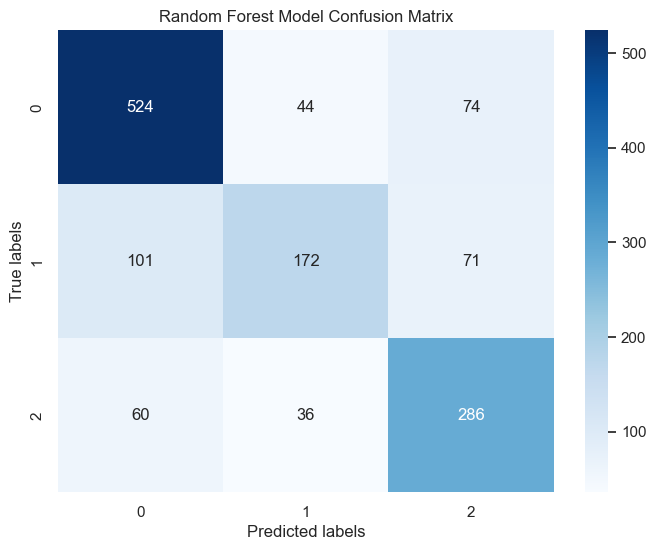

In [29]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Model Confusion Matrix')
plt.show()

- The main diagonal shows that the RF model is more effective at predicting Class 0 (Home Team Win) and Class 2 (Away Team Win) compared to Class 1 (Draw), which is consistent with the classification report above.
- There seems to be more confusion between Class 0 (Home Team Win) and Class 2 (Away Team Win), given the higher number of false positives for these classes.
- Class 1 (Draw) has the most room for improvement, both in terms of reducing false negatives and false positives.

#### ROC Curves

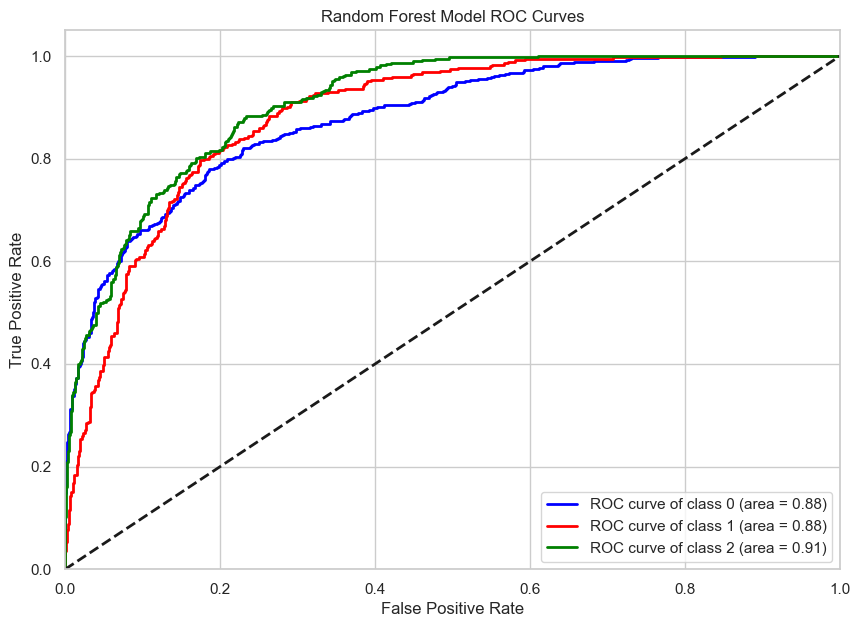

In [30]:
# Probabilities for each class from the RF model
rf_y_probs = best_rf_model.predict_proba(X_test)

# Generate the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], rf_y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Model ROC Curves')
plt.legend(loc="lower right")
plt.show()


All three classes have ROC cruves significantly above the diagonal line which indicates that the model has a good discrimitive ability for each class.

- **Class 0 (Home Team Win)**: With an AUC of 0.91, this class has the highest area under the ROC curve, which suggests that the model is most capable of distinguishing Class 0 from not-Class 0 instances.
- **Class 1 (Draw)**: The AUC for Class 1 is 0.89, slightly less than Class 0, indicating a strong but marginally weaker ability to discriminate Class 1 from other classes compared to Class 0.
- **Class 2 (Away Team Win)**: Class 2 has an AUC of 0.88, which is slightly lower than the other two classes but still indicates a good level of discrimination.


#### Key Contributors

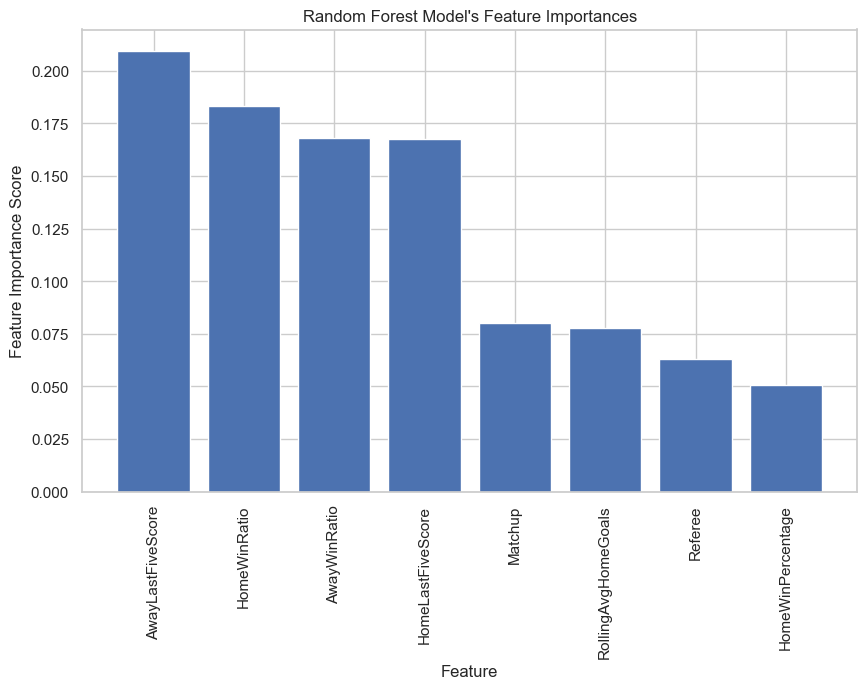

In [31]:
# Get feature importances from the trained model
feature_importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Get the feature names corresponding to the sorted importances
sorted_feature_names = [feature_names[i] for i in sorted_idx]

# Plot the top N features
no_features = len(feature_names)
plt.figure(figsize=(10, 6))
plt.bar(range(no_features ), feature_importances[sorted_idx][:no_features ])
plt.xticks(range(no_features ), sorted_feature_names[:no_features ], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score')
plt.title('Random Forest Model\'s Feature Importances'.format(no_features))
plt.show()

- `AwayLastFiveScore` has the highest feature importance score, which suggests it is the most significant predictor in the model. This implies that the last five scores of the away team have a strong influence on the model's predictions.
- `HomeLastFiveScore` is the second most important feature, indicating the last five scores of the home team are also highly predictive.
- `HomeWinPercentage` has the lowest feature importance score among the top eight features, suggesting that it has the least impact on the model's decision-making process.


**Potential Model Improvements**

Since `AwayLastFiveScore` and `HomeLastFiveScore` are highly valued by the model, ensuring the accuracy and relevance of these features could improve model performance. Given the lower importance of `HomeWinPercentage`, it may be worth exploring whether this feature could be engineered better or if additional related data could enhance its predictive power.

### Support Vector Machines

In [32]:
# SVM parameter grid definitions
svm_param_grid = {
    'C': [0.1, 1, 10],  # Regularisation parameter
    'kernel': ['rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'probability': [True]
}

# Initialise the SVM classifer
svm_model = SVC(random_state=1, probability=True)

# Initialise the GridSearhCV
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the SVM grid search
svm_grid_search.fit(X_train, y_train)

# Best SVM parameters
print("Best parameters found: ", svm_grid_search.best_params_)

# Use the best model
best_svm = svm_grid_search.best_estimator_

# Make predictions with the best SVM model
svm_y_pred = best_svm.predict(X_test)

# Evaluate the SVM model
print("Accuracy:", accuracy_score(y_test, svm_y_pred))
print("\nClassification Report:\n", classification_report(y_test, svm_y_pred))


Fitting 3 folds for each of 18 candidates, totalling 54 fits


Best parameters found:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
Accuracy: 0.7353801169590644

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       642
           1       0.72      0.54      0.62       344
           2       0.71      0.77      0.74       382

    accuracy                           0.74      1368
   macro avg       0.73      0.71      0.71      1368
weighted avg       0.73      0.74      0.73      1368



**Class 0 (Home Team Win) Performance**

- The model demonstrates the highest precision (0.76) with Class 0, meaning that when it predicts an instance as Class 0, it is correct about 76% of the time.
- Class 0 also has the highest recall (0.82), indicating that the model is able to identify 82% of all actual Class 0 instances correctly.
- The F1-score, which balances precision and recall, is the highest among all classes at 0.79.

**Class 1 (Draw) Performance**

- Class 1 has a lower recall of 0.54, which suggests that the model misses nearly half of the actual Class 1 instances.
- The precision for Class 1 is reasonably good at 0.72, but because of the lower recall, the F1-score is significantly lower at 0.62.

**Class 2 (Away Team Win) Performance**

- Class 2 has a recall of 0.77, which is relatively high and indicates that the model correctly identifies 77% of the actual Class 2 instances.
- The precision for Class 2 is 0.71, slightly lower than for Class 0, indicating that there are some instances where the model incorrectly identifies other classes as Class 2.
- The F1-score for Class 2 is 0.74, reflecting a better balance between precision and recall compared to Class 1 but still lower than Class 0.

**Overall Model Performance**

- The model has an overall accuracy of 0.74, meaning it correctly predicts the class of an instance 74% of the time across all classes.

#### Confusion Matrix

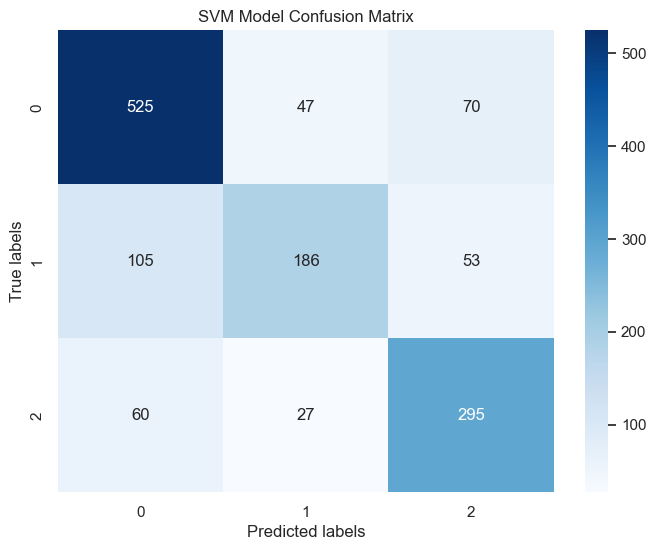

In [33]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, svm_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVM Model Confusion Matrix')
plt.show()

The model appears to most frequently confuse Class 1 (Draw) with Class 0 (Home Team Win), as indicated by the higher false negatives for Class 1. Class 0 (Home Team Win) and Class 2 (Away Team Win) have the most significant confusion, given the higher false positives for both classes.

**Class 0 (Homew Team Win)**: Has a high number of true positives (525), indicating that the model is effective at identifying this class 0.

**Class 1 (Draw)**: Has a moderate number of true positives (186) but also a high number of false negatives (105), suggesting the model struggles to identify all instances of Class 1 accurately.

**Class 2 (Away Team Win)**: Has a strong number of true positives (295), which implies that the model is has a moderate ability to predicti Class 2.

#### ROC Curves

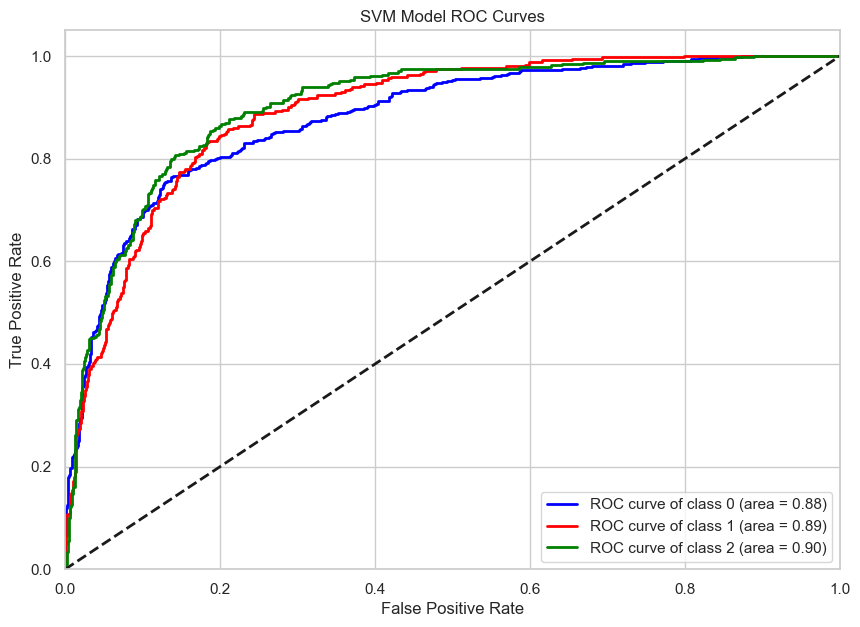

In [34]:
# Probabilities for each class from the SVM model
svm_y_probs = best_svm.predict_proba(X_test)

# Generate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], svm_y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Model ROC Curves')
plt.legend(loc="lower right")
plt.show()


Despite the overlaps, each class's ROC curve is distinct, which indicates that the model has learned to differentiate between each class effectively. Class 2 (Away Team Win) has the highest AUC of 0.90, which suggests that the model is best at distinguishing instances of this class. While Class 0 (Home Team Win) and Class 1 (Draw) have AUCs of 0.88 and 0.89, respectively. These are very close and indicate a good ability to discriminate these classes from others, although they are slightly less effective than Class 2.

#### Key Contribuors

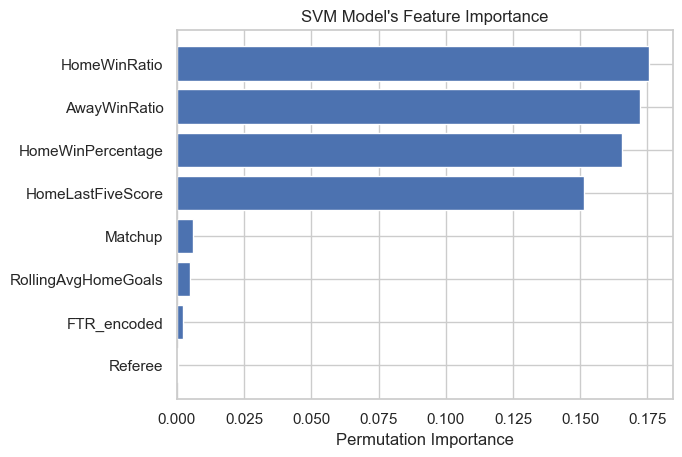

In [35]:
# Determine support vectors for features
support_vectors = best_svm.support_vectors_

# Determine permutation importance
perm_importance = permutation_importance(best_svm, X_test, y_test, n_repeats=30, random_state=1)

# Sorting the features by their importance
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('SVM Model\'s Feature Importance')
plt.show()

**Key Observations**

- `HomeWinPercentage` has the highest importance, suggesting it's a strong predictor in the model.
- `AwayWinRatio` and `HomeLastFiveScore` also show significant importance, indicating their substantial role in predictions.
- `Referee` and `Matchup` have the least importance, implying they have a minimal impact on the model's predictive capability.
- The rest of the features have moderate importance with `RollingAvgHomeGoals` slightly more influential than HomeWinRatio.

### Model Performance Conclusion

The Logistic Regression model emerges as the best performer with the highest overall accruacy and a balanced precision-recall trade-off. The SVM model shows strength in predicting Class 2 (Away Team Wins), which could make it preferable in scenarios where predicting Away Team Wins is preferred. The Random Forest model, while slightly less accruate, still shows a robust feature usage.

### References
1. Statology (2022) How to Plot Multiple ROC Curves in Python (With Example). Available at: https://www.statology.org/plot-multiple-roc-curves-python/. Accessed on 9 December 2023.
2. Versloot, C. (n.d.). How to visualize support vectors of your SVM classifier. Available at https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-visualize-support-vectors-of-your-svm-classifier.md. Accessed on 9 December 2023.